In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm
from igs.igs import iterative_greedy_search_
from igs.get_true_pf import *
from igs.get_expected_pf import *
from baselines.random_allocation import *

In [2]:
import pickle
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from prediction.helpers import *
from sklearn.metrics import classification_report, accuracy_score

def split_train_test_(train_data, val_data, test_data):
    train_x = [x['features'] for x in train_data]
    train_y = [list(y['label'].values()) for y in train_data]
    test_x = [x['features'] for x in test_data]
    test_y = [list(y['label'].values()) for y in test_data]
    val_x = [x['features'] for x in val_data]
    val_y = [list(y['label'].values()) for y in val_data]

    return train_x, train_y, val_x, val_y, test_x, test_y

def get_accuracy_(y_pred, y_true, model_list):
    df_y_pred = pd.DataFrame(y_pred, columns=model_list)
    df_y_true = pd.DataFrame(y_true, columns=model_list)
    accuracy = []
    for model_name in model_list:
        accuracy.append(accuracy_score(df_y_true[model_name], df_y_pred[model_name]))
    return accuracy

def get_llm_score_(val_y, val_pred, model_list):
    report = classification_report(val_y, val_pred, digits=3, target_names=model_list)
    lines = report.split('\n')
    scores_data = []
    for line in lines[2:-5]:  # Skip the first 2 and last 5 lines which contain headers and averages
        row_data = line.split()
        if len(row_data) < 2 or row_data[0] == 'micro' or row_data[0] == 'macro' or row_data[0] == 'weighted':
            continue  # Skip lines that are not relevant to individual classes
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        scores_data.append([class_name, precision, recall, f1_score, support])
    scores_df = pd.DataFrame(scores_data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
    scores_df['Accuracy'] = get_accuracy_(val_pred, val_y, model_list)
    scores_df.set_index('Class', inplace=True)
    return scores_df

def get_llm_ability_(train_data, val_data, model_list):
    train_label = pd.DataFrame([x['label'] for x in train_data])
    val_label = pd.DataFrame([x['label'] for x in val_data])
    data = pd.concat([train_label, val_label])
    score = pd.DataFrame(data.sum(axis=0) / len(data), columns=['score'])
    score["model"] = score.index
    score = score.reset_index(drop=True)

    df_sorted = score.sort_values(by='score', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)
    df_sorted['order'] = df_sorted.index + 1
    df_sorted_custom_order = df_sorted.set_index('model').loc[model_list].reset_index()
    df_sorted_custom_order.set_index('model', inplace=True, drop=True)
    return df_sorted_custom_order

def get_predict_accuracy_and_score_(model_list, train_data, val_data, test_data):
    train_x, train_y, val_x, val_y, test_x, test_y = split_train_test_(train_data, val_data, test_data)
    clf = MultiOutputClassifier(estimator=XGBClassifier(n_jobs=-1, max_depth=100, n_estimators=1000))
    clf.fit(train_x, train_y)

    val_pred = clf.predict(val_x[0:])
    # val_score = clf.predict_proba(val_x[0:])
    df_llm_scores = get_llm_score_(val_y, val_pred, model_list)
    
    y_pred = clf.predict(test_x[0:])
    y_score = clf.predict_proba(test_x[0:])

    print(classification_report(test_y, y_pred, digits=3, target_names=model_list))
    print(accuracy_score(test_y, y_pred))
    complexity = [[y_score[j][i][1] for j in range(len(model_list))] for i in range(len(y_score[0]))]
    df_pre_accuracy = pd.DataFrame(complexity, columns=model_list)
    df_pre_binary_accuracy = pd.DataFrame(y_pred, columns=model_list)
    df_true_accuracy = pd.DataFrame(test_y, columns=model_list)
    return df_pre_accuracy, df_true_accuracy, df_llm_scores, df_pre_binary_accuracy

def data_preprocess(data_dir, model_list, test_size=0.98):
    print(test_size)
    with open(data_dir, mode="rb") as f:
        X, Y, cost = pickle.load(f)
    # with open(f"{data_dir}/{dataset}_query_word2vec.pkl", mode="rb") as f:
    #     X, Y, cost = pickle.load(f)

    data_dict = {}
    for i in range(len(X)):
        infor_dict = {}
        infor_dict['features'] = X[i]['features']
        infor_dict['label'] = Y[i]
        infor_dict['cost'] = cost[i]
        data_dict[i] = infor_dict

    train_data, test_data = train_test_split(data_dict, test_size=test_size, random_state=42)
    train_data, val_data= train_test_split(train_data, test_size=0.5, random_state=42)
    
    print("There are",len(train_data), "train data and ", len(val_data), "val data and ", len(test_data), "test data")

    df_pre_accuracy, df_true_accuracy, df_llm_scores, df_pre_binary_accuracy = get_predict_accuracy_and_score_(model_list, train_data, val_data, test_data)
    text_cost = [x['cost'] for x in test_data]
    df_cost = pd.DataFrame(text_cost)
    
    llm_ability = get_llm_ability_(train_data, val_data, model_list)

    return df_pre_accuracy, df_true_accuracy, df_cost, df_llm_scores, llm_ability, df_pre_binary_accuracy

C:\Users\LYue7\anaconda3\envs\llms\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\LYue7\anaconda3\envs\llms\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
dataset = "agnews"
test_size= 0.99
data_dir = f"datasets/text_classification/{dataset}_content_word2vec.pkl"
model_list = ['gptneox_20B', 'gptj_6B', 'fairseq_gpt_13B', 'text-davinci-002', 'text-curie-001', 'gpt-3.5-turbo', 'gpt-4', 'j1-jumbo', 'j1-grande', 'j1-large', 'xlarge', 'medium']
df_pre_accuracy, df_true_accuracy, df_cost, df_llm_scores, df_llm_ability, df_pre_binary_accuracy = data_preprocess(data_dir, model_list, test_size=test_size)
df_difficulty = df_pre_binary_accuracy.sum(axis=1)/max(df_pre_binary_accuracy.sum(axis=1))

0.99
There are 38 train data and  38 val data and  7524 test data


C:\Users\LYue7\anaconda3\envs\llms\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

     gptneox_20B      0.578     0.745     0.651      3651
         gptj_6B      0.751     0.772     0.762      4982
 fairseq_gpt_13B      0.739     0.979     0.842      5438
text-davinci-002      0.889     0.979     0.932      6683
  text-curie-001      0.698     0.877     0.777      4910
   gpt-3.5-turbo      0.874     0.975     0.922      6562
           gpt-4      0.896     0.996     0.943      6742
        j1-jumbo      0.816     0.992     0.895      6133
       j1-grande      0.749     0.959     0.841      5599
        j1-large      0.703     0.891     0.786      5150
          xlarge      0.844     0.990     0.911      6329
          medium      0.656     0.546     0.596      4506

       micro avg      0.780     0.909     0.840     66685
       macro avg      0.766     0.892     0.822     66685
    weighted avg      0.782     0.909     0.838     66685
     samples avg      0.774     0.884     0.799     66685

0.129319510

C:\Users\LYue7\anaconda3\envs\llms\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
len(df_true_accuracy)

7524

In [5]:
def get_score_table(df_pre_accuracy, df_llm_scores, df_llm_ability, df_difficulty, model_list):
    score_table = []
    for i in range(len(df_pre_accuracy)):
        accuracy = []
        for model_name in model_list:
            accuracy.append(df_pre_accuracy.iloc[i][model_name] * df_llm_scores.loc[model_name]["Accuracy"] * df_llm_ability.loc[model_name]["score"] * df_difficulty.iloc[i])
        score_table.append(accuracy)
    
    score_table_df = pd.DataFrame(score_table, columns=model_list)
    return score_table_df

In [68]:
score_table_df = get_score_table(df_pre_accuracy, df_llm_scores, df_llm_ability, df_difficulty, model_list)
igs_res, igs_solution = iterative_greedy_search_(score_table_df, df_true_accuracy, df_cost, model_list).run()

----------Start to get expected pareto front by IGS!----------
1
2
3
4
5
6
7
8
9
10
11


100%|██████████| 12/12 [00:00<00:00, 25.26it/s]

IGS finished and the searchiing time is:  26.23282551765442


In [126]:
igs_old_res, igs_old_solution = iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).run()

----------Start to get expected pareto front by IGS!----------
1
2
3
4
5
6
7
8
9
10
11
12


100%|██████████| 13/13 [00:00<00:00, 23.96it/s]

IGS finished and the searchiing time is:  23.887734174728394


In [103]:
from main import get_single_model_results_
single_model_res = {}
model_list = ['gptneox_20B', 'gptj_6B', 'fairseq_gpt_13B', 'text-davinci-002', 'text-curie-001', 'gpt-3.5-turbo', 'gpt-4', 'j1-jumbo', 'j1-grande', 'j1-large', 'xlarge', 'medium']
model_name = ['GPT-Neo', 'GPT-J', 'FSQ', 'Text-D', 'Text-C', 'GPT-3.5', 'GPT-4', 'J1-J', 'J1-G', 'J1-L', 'CoHere-XL', 'CoHere-M']
for i in range(len(model_list)):
    single_model_res[model_name[i]] = get_single_model_results_(model_list[i], df_true_accuracy, df_cost)

In [25]:
save_dir = f"output/text_classification/{dataset}_{test_size}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if os.path.exists(f"{save_dir}/{dataset}_true_pt.csv"):
    true_pt = pd.read_csv(f"{save_dir}/{dataset}_true_pt.csv")
    # true_pt_solution = pd.read_csv(f"{save_dir}/{dataset}_true_pt_solution.csv")
else:
    true_pt, true_pt_solution = get_true_pareto_front(df_true_accuracy, df_cost, model_list).run()
    true_pt.to_csv(f"{save_dir}/{dataset}_true_pt.csv")
    # true_pt_solution = pd.DataFrame(true_pt_solution)
    # true_pt_solution.to_csv(f"{save_dir}/{dataset}_true_pt_solution.csv")   

# if os.path.exists(f"{save_dir}/{dataset}_expected_pt.csv"):
#     expected_pt = pd.read_csv(f"{save_dir}/{dataset}_expected_pt.csv")
# else:
#     expected_pt, expected_pt_solution = get_expected_pareto_front(df_pre_accuracy, df_true_accuracy, df_cost, model_list).run()
#     expected_pt.to_csv(f"{save_dir}/{dataset}_expected_pt.csv")

In [65]:
# find the point that has the same accuracy in single_model_res
def get_same_accuracy_point_(single_model_res, true_pt):
    same_accuracy_point = []
    same_accuracy_point.append([true_pt.iloc[0]["cost"], true_pt.iloc[0]["true_accuracy"]])
    for i in range(len(true_pt)):
        true_accuracy = true_pt.iloc[i]["true_accuracy"]
        same_accuracy = []
        for key, value in single_model_res.items():
            if true_accuracy == value[1]:
                same_accuracy_point.append([true_pt.iloc[i]["cost"], true_accuracy])
                continue
    same_accuracy_point.append([true_pt.iloc[-1]["cost"], true_pt.iloc[-1]["true_accuracy"]])
    same_accuracy_point = np.array(same_accuracy_point)
    same_accuracy_point = same_accuracy_point[same_accuracy_point[:, 0].argsort()]
    return same_accuracy_point

In [66]:
same_accuracy_point = get_same_accuracy_point_(single_model_res, true_pt)

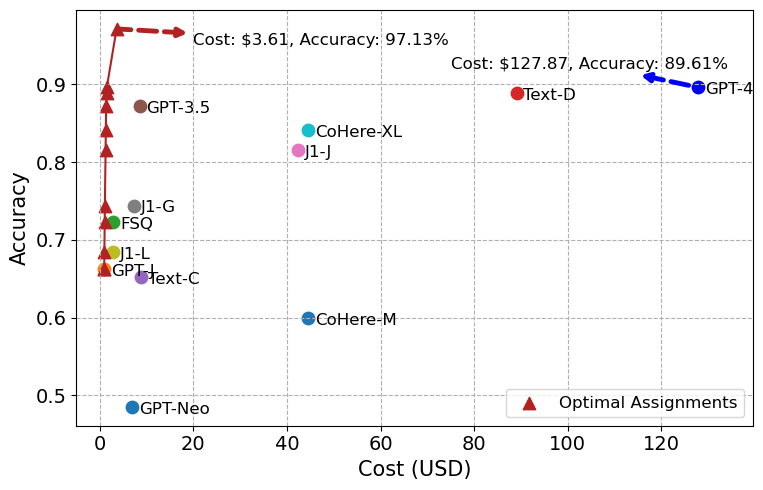

In [185]:
fig = plt.figure(figsize=(8, 5))
font = {  # 'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 15,
}
for key, value in single_model_res.items():
    if key == 'GPT-4':
        plt.scatter(value[0], value[1], alpha=1, c="blue", s=80)
        plt.annotate(key, (value[0], value[1]), xytext=(5, -5), textcoords='offset points', fontsize=12)
    else:
        plt.scatter(value[0], value[1], alpha=1, s=80)
        plt.annotate(key, (value[0], value[1]), xytext=(5, -5), textcoords='offset points', fontsize=12)

plt.scatter([x[0] for x in same_accuracy_point], [x[1] for x in same_accuracy_point],  alpha=1, marker="^", c="firebrick", s=80, label='Optimal Assignments')
plt.plot([x[0] for x in same_accuracy_point], [x[1] for x in same_accuracy_point], alpha=1, c="firebrick")

plt.annotate('Cost: $3.61, Accuracy: 97.13%', xy=(same_accuracy_point[-1][0], same_accuracy_point[-1][1]), xytext=(20, 0.95),arrowprops=dict(arrowstyle= '<|-',
                             color='firebrick',
                             lw=3.5,
                             ls='--'), fontsize=12)
plt.annotate('Cost: $127.87, Accuracy: 89.61%', xy=(single_model_res['GPT-4'][0], single_model_res['GPT-4'][1]), xytext=(75, 0.92),arrowprops=dict(arrowstyle= '<|-',
                             color='blue',
                             lw=3.5,
                             ls='--'), fontsize=12)

plt.xlabel('Cost (USD)', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--')
plt.legend(loc='lower right', fontsize=12)
# lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.47, -0.13), ncol=7, fontsize=12)
plt.tight_layout()
plt.xlim(-5, 139.5)
plt.show()
fig.savefig(f"Figures/Motivation_{dataset}.pdf", dpi=500)

In [26]:
def get_true_nondominated_res_(pd_res):
    true_df = pd_res.copy()
    pareto_efficient_mask = is_pareto_(costs=true_df.copy())
    true_df = true_df[pareto_efficient_mask]
    true_df = pd.DataFrame(true_df, columns=['cost', 'accuracy']).sort_values(by=['cost'])

    return true_df

def get_alg_pt(alg_res, pt_type, non_dominate):
    alg_pt = pd.DataFrame()
    if pt_type == 'true_pt':
        alg_pt['cost'] = alg_res['cost']
        alg_pt['accuracy'] = alg_res['true_accuracy']
    elif pt_type == 'expected_pt':
        alg_pt['cost'] = alg_res['cost']
        alg_pt['accuracy'] = alg_res['expected_accuracy']
    if non_dominate:
        alg_pt = get_true_nondominated_res_(alg_pt)
    return alg_pt

In [30]:
non_pt = get_alg_pt(expected_pt, pt_type='true_pt', non_dominate=True)
print(f"Number of non-dominated solutions: {len(non_pt)}")
print(f"Number of dominated solutions: {len(expected_pt) - len(non_pt)}")

Number of non-dominated solutions: 1417
Number of dominated solutions: 16087


In [11]:
exp_res = []
for i in range(len(true_pt_solution)):
    exp_res.append(iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).ls_fitness_function_(true_pt_solution.iloc[i].to_list()))

In [5]:
s_allocation = true_pt_solution[-1]


In [13]:
n = 0
true_acc = 0
for i, allocation in enumerate(s_cheapest):
    if df_pre_accuracy.iloc[i, allocation] < 0.5:
        n = n+1
        true_acc += df_true_accuracy.iloc[i, allocation]
        # print(f"Index {i}, Allocation {allocation}: {df_pre_accuracy.iloc[i, allocation]}")
        # print(f"Index {i}, Allocation {allocation}: {df_true_accuracy.iloc[i, allocation]}")
        
print(f"Total count where condition is met: {n}")
print(f"The sum is {true_acc}")

Total count where condition is met: 1772
The sum is 522


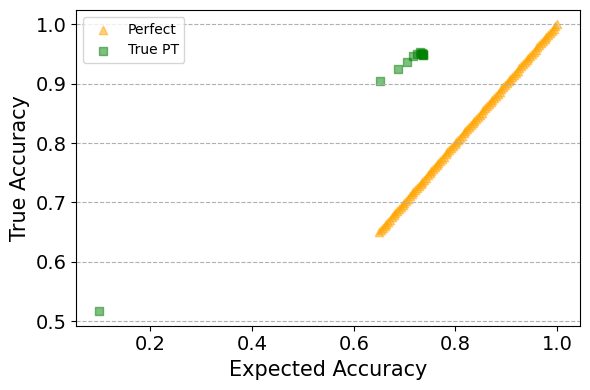

In [71]:
fig = plt.figure(figsize=(6,4))
font = {  # 'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 15,
}

# plt.scatter(expected_pt['expected_accuracy'], expected_pt["true_accuracy"], alpha=0.5, marker="^", c="firebrick", label='Prediction')
plt.scatter(np.linspace(0.65, 1, 100), np.linspace(0.65, 1, 100), alpha=0.5, marker="^", c="orange", label='Perfect')
plt.scatter(igs_res['expected_accuracy'], igs_res["true_accuracy"], alpha=0.5, marker="s", c="green", label='True PT')

plt.xlabel('Expected Accuracy', fontdict=font)
plt.ylabel('True Accuracy', fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0, linestyle='--', axis='y')
plt.legend()
# lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.47, -0.13), ncol=7, fontsize=12)
plt.tight_layout()
plt.show()
# fig.savefig(f"{save_dir}/Comparison_{dataset}.png", dpi=500)

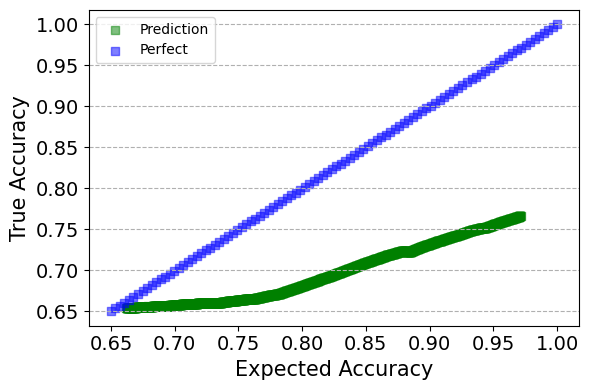

In [49]:
fig = plt.figure(figsize=(6,4))
font = {  # 'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 15,
}

plt.scatter(true_pt['true_accuracy'], [x[1] for x in exp_res], alpha=0.5, marker="s", c="green", label='Prediction')
plt.scatter(np.linspace(0.65, 1, 100), np.linspace(0.65, 1, 100), alpha=0.5, marker="s", c="blue", label='Perfect')

plt.xlabel('Expected Accuracy', fontdict=font)
plt.ylabel('True Accuracy', fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0, linestyle='--', axis='y')
plt.legend()
# lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.47, -0.13), ncol=7, fontsize=12)
plt.tight_layout()
plt.show()
# fig.savefig(f"{save_dir}/Comparison_{dataset}.png", dpi=500)

In [18]:
part_res = expected_pt[expected_pt["expected_accuracy"] < 0.90]

In [17]:
single_model_res

{'gptneox_20B': [6.672644999999525, 0.485595567867036],
 'gptj_6B': [0.9267625999999864, 0.6630193905817174],
 'fairseq_gpt_13B': [2.7450197999999864, 0.7249307479224377],
 'text-davinci-002': [85.43868, 0.8887811634349031],
 'text-curie-001': [8.539201999999957, 0.6544321329639889],
 'gpt-3.5-turbo': [8.17125799999992, 0.8724376731301939],
 'gpt-4': [122.69595, 0.8965373961218837],
 'j1-jumbo': [40.7095, 0.8142659279778394],
 'j1-grande': [7.088400000000002, 0.743213296398892],
 'j1-large': [2.6698199999992784, 0.6832409972299169],
 'xlarge': [42.67440749999986, 0.8411357340720221],
 'medium': [42.67440749999986, 0.5994459833795014]}

In [61]:
print(same_accuracy_point)

None


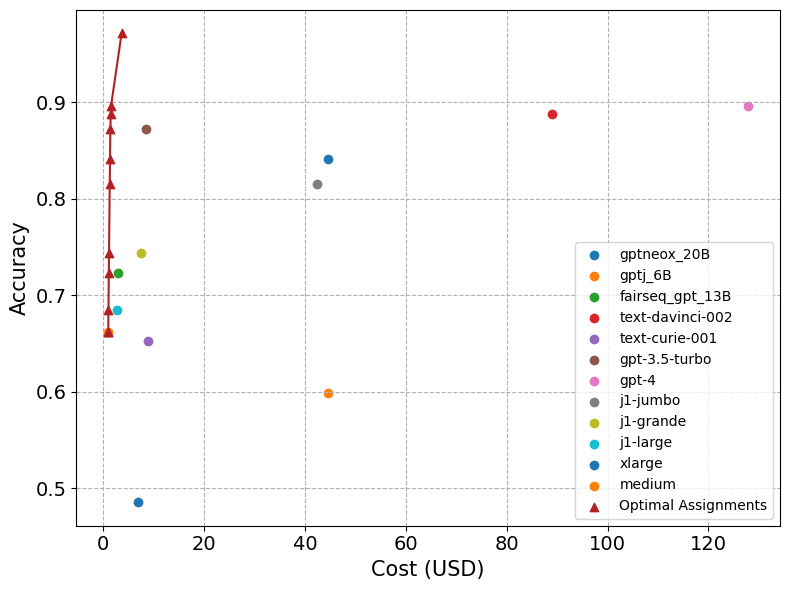

In [71]:
fig = plt.figure(figsize=(8, 6))
font = {  # 'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 15,
}
for key, value in single_model_res.items():
    plt.scatter(value[0], value[1], alpha=1, label=key)

# plt.scatter(true_pt['cost'], true_pt["true_accuracy"], alpha=0.5, marker="s", c="green", label='True PT')
plt.scatter([x[0] for x in same_accuracy_point], [x[1] for x in same_accuracy_point],  alpha=1, marker="^", c="firebrick", label='Optimal Assignments')
plt.plot([x[0] for x in same_accuracy_point], [x[1] for x in same_accuracy_point], alpha=1, c="firebrick")

# plt.scatter([x[0] for x in exp_res], [x[1] for x in exp_res],  alpha=0.5, marker="s", c="blue", label='True PT with expectation accuracy')
# plt.scatter(non_pt['cost'], non_pt["accuracy"], alpha=0.5, marker="^", c="firebrick", label='expected PT')
# plt.scatter(expected_pt['cost'], expected_pt["true_accuracy"], alpha=0.5, marker="^", c="firebrick", label='expected PT')
# plt.scatter(expected_pt['cost'], expected_pt["expected_accuracy"], alpha=0.5, marker="^", c="green", label='true result of expected PT')
# plt.scatter(igs_res['cost'], igs_res["true_accuracy"], alpha=1, marker="^", c="firebrick",label='IGAP-Precision')
# plt.scatter(igs_old_res['cost'], igs_old_res["true_accuracy"], alpha=1, marker="^", c="blue",label='IGAP_old')
plt.xlabel('Cost (USD)', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(zorder=0, linestyle='--')
plt.legend()
# lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.47, -0.13), ncol=7, fontsize=12)
plt.tight_layout()
plt.show()
# fig.savefig(f"{save_dir}/Comparison_{dataset}.png", dpi=500)

In [72]:
### Robust heuristic

In [73]:
density = 100

s_cheapest, s_high_accuracy = iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).get_exreme_solution_()
res_cheapest = iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).ls_fitness_function_(s_cheapest)
res_high_accuracy = iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).ls_fitness_function_(s_high_accuracy)

ls_solutions = [s_cheapest, s_high_accuracy]
nondominated_res = np.vstack([res_cheapest, res_high_accuracy])
cost_diff = res_high_accuracy[0] - res_cheapest[0]
acc_diff = res_high_accuracy[1] - res_cheapest[1]
cost_grid = np.linspace(0, cost_diff, density)

In [11]:
def get_true_acc(solution, df_true_accuracy):
    res = 0
    for i in range(len(solution)):
        res += df_true_accuracy.iloc[i, solution[i]]
    return (res / len(solution))

In [74]:
# robust score table
def single_job_score_table_generation(df_pre_accuracy, df_cost, current_allocation, job_id):
    accuracy = df_pre_accuracy.iloc[job_id]
    cost_list = df_cost.iloc[job_id]

    accuracy_diff = []
    cost_list_diff = []
    job_index = []
    for ele in range(len(cost_list)):
        if ele != current_allocation[job_id]:
            cost_list_diff.append(cost_list.iloc[ele] - cost_list.iloc[current_allocation[job_id]])
            accuracy_diff.append(accuracy.iloc[ele] - accuracy.iloc[current_allocation[job_id]])
            job_index.append(ele)

    accuracy_change_unit_cost = []
    accuracy_change_unit_cost_index = []

    cost_diff_copy = cost_list_diff.copy()
    accuracy_diff_copy = accuracy_diff.copy()
    for i in range(len(cost_list_diff)):
        if cost_list_diff[i] <= 0 and accuracy_diff[i] >= 0 and (accuracy_diff[i] - cost_list_diff[i]) > 0:
            accuracy_change_unit_cost.append(float('inf'))
            accuracy_change_unit_cost_index.append(job_index[i])
        elif cost_list_diff[i] > 0 and accuracy_diff[i] > 0:
            accuracy_change_unit_cost.append(accuracy_diff[i] / cost_list_diff[i])  # bigger is better
            accuracy_change_unit_cost_index.append(job_index[i])
        elif cost_list_diff[i] < 0 and accuracy_diff[i] < 0:
            accuracy_change_unit_cost.append(-accuracy_diff[i] / cost_list_diff[i])  # bigger is worse
            accuracy_change_unit_cost_index.append(job_index[i])
        else:
            accuracy_change_unit_cost.append(float('-inf'))
            accuracy_change_unit_cost_index.append(job_index[i])
            cost_diff_copy[i] = float('-inf')
            accuracy_diff_copy[i] = float('-inf')
    return accuracy_diff_copy, cost_diff_copy, accuracy_change_unit_cost, accuracy_change_unit_cost_index

In [76]:
def score_table_generation(current_allocation):
    accuracy_diff_list = []
    cost_list_diff_list = []
    accuracy_change_unit_cost_list = []
    accuracy_change_unit_cost_index_list = []
    for i in range(len(current_allocation)):
        accuracy_diff, cost_list_diff, accuracy_change_unit_cost, accuracy_change_unit_cost_index = (
            single_job_score_table_generation(df_pre_accuracy, df_cost, current_allocation, i))
        accuracy_diff_list.append(accuracy_diff)
        cost_list_diff_list.append(cost_list_diff)
        accuracy_change_unit_cost_list.append(accuracy_change_unit_cost)
        accuracy_change_unit_cost_index_list.append(accuracy_change_unit_cost_index)

    return np.array(accuracy_diff_list), np.array(cost_list_diff_list), np.array(
        accuracy_change_unit_cost_list), np.array(accuracy_change_unit_cost_index_list)

In [ ]:
df_llm_scores, df_llm_ability, df_difficulty

In [77]:
np_acc_diff_list, np_cost_list_diff_list, np_accuracy_change_unit_cost_list, np_index_list = score_table_generation(s_cheapest)

In [81]:
np_accuracy_change_unit_cost_list

array([[         -inf, 2339.93700072,   56.80947796, ...,          -inf,
         105.72308422,   88.05823868],
       [ 931.98757364,   66.3459988 ,  161.92544716, ..., 2905.39655053,
         302.29302708,          -inf],
       [1510.0211273 ,  860.17737263,  131.92672181, ..., 2879.86380139,
         214.54497652,   72.01855371],
       ...,
       [1950.96372611,          -inf,  152.7628873 , ..., 2253.86862616,
         276.54055198,    4.97984626],
       [1552.01347748,          -inf,  112.11563363, ...,  205.60532725,
         124.5288423 ,          -inf],
       [1782.7867347 ,  409.56683868,  136.44142887, ..., 1478.44791245,
         245.30227483,   58.24443977]])

In [18]:
s_destruction = iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).destruction(cost_grid[0], s_high_accuracy)

In [70]:
df_llm_scores

,Precision,Recall,F1-Score,Support,Accuracy
Class,,,,,
gptneox_20B,0.838,0.705,0.765,44,0.648148
gptj_6B,0.500,0.320,0.390,25,0.537037
fairseq_gpt_13B,0.741,0.556,0.635,36,0.574074
text-davinci-002,0.963,1.000,0.981,52,0.962963
text-curie-001,0.826,0.905,0.864,42,0.777778
gpt-3.5-turbo,0.926,1.000,0.962,50,0.925926
gpt-4,0.981,1.000,0.991,53,0.981481
j1-jumbo,0.757,0.700,0.727,40,0.611111
j1-grande,0.690,0.806,0.744,36,0.629630


In [92]:
wrong_job_info_data = []
for j_index in range(len(s_high_accuracy)):
    if df_pre_accuracy.iloc[j_index, s_high_accuracy[j_index]] > 0.5 and df_true_accuracy.iloc[j_index, s_high_accuracy[j_index]] == 0:
        j_allocation = s_high_accuracy[j_index]
        print(f"Job index {j_index}, Predict accuracy: {df_pre_accuracy.iloc[j_index, j_allocation]}, True accuracy: {df_true_accuracy.iloc[j_index, j_allocation]}, job difficult: {job_difficulty.iloc[j_index]}, LLMs score: {df_llm_scores.iloc[j_allocation]['Precision']}, LLMs ability: {df_llm_ability.iloc[j_allocation]['order']}")
        
        # Create a dictionary for the current row
        row_data = {
            "job_index": j_index,
            "allocation": j_allocation,
            "predict_accuracy": df_pre_accuracy.iloc[j_index, j_allocation],
            "true_accuracy": df_true_accuracy.iloc[j_index, j_allocation],
            "job_difficulty": job_difficulty.iloc[j_index],
            "llm_score": df_llm_scores.iloc[j_allocation]['Precision'],
            "llm_ability": df_llm_ability.iloc[j_allocation]['order']
        }
        
        # Append the dictionary to the list
        wrong_job_info_data.append(row_data)

# Convert the list of dictionaries into a DataFrame
wrong_job_info = pd.DataFrame(wrong_job_info_data)


Job index 1, Predict accuracy: 0.9814103841781616, True accuracy: 0, job difficult: 10, LLMs score: 0.853, LLMs ability: 2
Job index 12, Predict accuracy: 0.9971580505371094, True accuracy: 0, job difficult: 11, LLMs score: 0.712, LLMs ability: 7
Job index 16, Predict accuracy: 0.9954074025154114, True accuracy: 0, job difficult: 9, LLMs score: 0.908, LLMs ability: 1
Job index 21, Predict accuracy: 0.9916777610778809, True accuracy: 0, job difficult: 7, LLMs score: 0.811, LLMs ability: 4
Job index 23, Predict accuracy: 0.9965941309928894, True accuracy: 0, job difficult: 12, LLMs score: 0.568, LLMs ability: 12
Job index 39, Predict accuracy: 0.9840250611305237, True accuracy: 0, job difficult: 12, LLMs score: 0.811, LLMs ability: 4
Job index 43, Predict accuracy: 0.9851509928703308, True accuracy: 0, job difficult: 12, LLMs score: 0.712, LLMs ability: 7
Job index 44, Predict accuracy: 0.9969275593757629, True accuracy: 0, job difficult: 12, LLMs score: 0.811, LLMs ability: 4
Job index 

In [95]:
wrong_job_info['job_difficulty'].value_counts()

job_difficulty
11    362
12    282
10    237
9     155
8      67
7      41
6       7
5       2
4       1
Name: count, dtype: int64

In [87]:
job_difficulty.value_counts()

12    2810
11    2116
10    1180
9      634
8      378
7      246
6       67
5       15
4        2
Name: count, dtype: int64

In [83]:
df_true_accuracy.iloc[7440]

gptneox_20B         1
gptj_6B             0
fairseq_gpt_13B     0
text-davinci-002    0
text-curie-001      0
gpt-3.5-turbo       0
gpt-4               0
j1-jumbo            0
j1-grande           1
j1-large            1
xlarge              0
medium              1
Name: 7440, dtype: int64

In [68]:
df_llm_ability

,score,model,order
0,0.907895,text-davinci-002,1
1,0.875000,gpt-4,2
2,0.861842,gpt-3.5-turbo,3
3,0.861842,j1-jumbo,4
4,0.861842,xlarge,5
5,0.796053,j1-grande,6
6,0.763158,j1-large,7
7,0.723684,fairseq_gpt_13B,8
8,0.644737,text-curie-001,9
9,0.618421,gptj_6B,10


In [39]:
score_able = []
for j_index in range(len(s_high_accuracy)):
    j_allocation = s_high_accuracy[j_index]
    score.append(df_pre_accuracy.iloc[j_index][j_allocation] * df_llm_scores.iloc[j_allocation]["Precision"] * df_llm_ability[j_allocation])

C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\1678476079.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  score.append(df_pre_accuracy.iloc[j_index][j_allocation] * df_llm_scores.iloc[j_allocation]["Precision"] * df_llm_ability[j_allocation])


In [96]:
score

[0.6940273374322998,
 0.7325001754909753,
 0.7255537907034159,
 0.7290495646744967,
 0.5405883291771537,
 0.6351434513142235,
 0.6957081881741944,
 0.5405504036702609,
 0.5279088882827445,
 0.5279742849069207,
 0.631346741475557,
 0.5404006772668738,
 0.5418241954602693,
 0.349574347470936,
 0.34834177745016004,
 0.5416992777146791,
 0.8205824287157311,
 0.723659208850641,
 0.8212023799858595,
 0.6946052991222395,
 0.7221153232290556,
 0.6931370856228628,
 0.8168788869004501,
 0.27186038847032346,
 0.6927283505158205,
 0.7349832406565546,
 0.6993171664248955,
 0.7236143983641737,
 0.6343660182074496,
 0.7331727965176105,
 0.7404538138061761,
 0.8200480235469969,
 0.6331983691767643,
 0.8198302519666523,
 0.6874940748202958,
 0.821142728654962,
 0.6943123813220545,
 0.683856536506038,
 0.6343467351637389,
 0.6877882007866314,
 0.8208525303351253,
 0.5411418278217316,
 0.6946329203000979,
 0.5352999394943839,
 0.6968064528660555,
 0.5308391744086617,
 0.7160612394288182,
 0.5240426045460

In [43]:
print(df_pre_accuracy.iloc[lowest_score_index][s_high_accuracy[lowest_score_index]])
print(df_true_accuracy.iloc[lowest_score_index][s_high_accuracy[lowest_score_index]])

0.969138
1


C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\2023144112.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_pre_accuracy.iloc[lowest_score_index][s_high_accuracy[lowest_score_index]])
C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\2023144112.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_true_accuracy.iloc[lowest_score_index][s_high_accuracy[lowest_score_index]])


In [80]:
def get_job_difficulty(df_pre_accuracy):
    df_p = df_pre_accuracy.applymap(lambda x: 1 if x >= 0.5 else 0)
    job_difficulty = df_p.sum(axis=1)
    return job_difficulty
job_difficulty = get_job_difficulty(df_pre_accuracy)

C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\3088504904.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p = df_pre_accuracy.applymap(lambda x: 1 if x >= 0.5 else 0)


In [33]:
job_difficulty = df_pre_accuracy.sum(axis=1)
j_index = job_difficulty.idxmin()
    
j_allocation = s_high_accuracy[j_index]
score = df_pre_accuracy.iloc[j_index][j_allocation] * df_llm_scores.iloc[j_allocation]["Precision"] * df_llm_ability[j_allocation]
print(df_llm_scores.iloc[j_allocation]["Precision"])
print(df_llm_ability[j_allocation])
print(score)
print(df_pre_accuracy.iloc[j_index][s_high_accuracy[j_index]])
print(df_true_accuracy.iloc[j_index][s_high_accuracy[j_index]])


0.811
0.8618421052631579
0.6933770940778288
0.99202114
1


C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\3341062349.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  score = df_pre_accuracy.iloc[j_index][j_allocation] * df_llm_scores.iloc[j_allocation]["Precision"] * df_llm_ability[j_allocation]
C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\3341062349.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_llm_ability[j_allocation])
C:\Users\LYue7\AppData\Local\Temp\ipykernel_2384\3341062349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Class        j1-jumbo
Precision       0.811
Recall          0.968
F1-Score        0.882
Support            62
Name: 7, dtype: object

In [29]:
s_high_accuracy[index]

7

In [19]:
true_res_high_accuracy = get_true_acc(s_high_accuracy, df_true_accuracy)
true_s_destruction = get_true_acc(s_destruction, df_true_accuracy)
res_s_destruction = iterative_greedy_search_(df_pre_accuracy, df_true_accuracy, df_cost, model_list).ls_fitness_function_(s_destruction)
print(f"Cost: {res_high_accuracy[0]}, Accuracy: {res_high_accuracy[1]}, True Accuracy: {true_res_high_accuracy}")
print(f"Cost: {res_s_destruction[0]}, Accuracy: {res_s_destruction[1]}, True Accuracy: {true_s_destruction}")

Cost: 38.16604109999991, Accuracy: 0.991155934489055, True Accuracy: 0.8450590762620838
Cost: 38.14605889999991, Accuracy: 0.9910766040840288, True Accuracy: 0.8449248120300752


In [ ]:
def get_robust_allocation_(df_pre_accuracy, df_cost, df_llm_scores, df_llm_ability, model_list, solution):
    new_s = solution.copy()
    # find the job has highest probility cannot be processed
    job_difficulty = df_pre_accuracy.sum(axis=1)
    j_index = job_difficulty.idxmin()
    
    j_allocation = new_s[j_index]
    score = df_pre_accuracy.iloc[j_index][j_allocation] * df_llm_scores.iloc[j_allocation] * df_llm_ability[j_allocation]
    
    
    return new_s

In [64]:
n = 0
m = 0
for i in range(len(s_high_accuracy)):
    if df_pre_accuracy.iloc[i, s_high_accuracy[i]] > 0.5 and df_true_accuracy.iloc[i, s_high_accuracy[i]] == 0:
        m = m+1
        if sum(df_true_accuracy.iloc[i]) == 0:
            n = n+1
        else:
            print(f"Index {i}, Allocation {s_high_accuracy[i]}: {df_pre_accuracy.iloc[i, s_high_accuracy[i]]}")
print(n, m)

Index 21, Allocation 3: 0.9967530369758606
Index 45, Allocation 4: 0.9945399165153503
Index 50, Allocation 1: 0.9960440397262573
Index 59, Allocation 9: 0.9977826476097107
Index 60, Allocation 3: 0.9859494566917419
Index 69, Allocation 5: 0.9817968606948853
Index 70, Allocation 4: 0.9983285069465637
Index 73, Allocation 10: 0.9826719760894775
Index 79, Allocation 9: 0.9969533681869507
Index 86, Allocation 3: 0.9901318550109863
Index 89, Allocation 3: 0.9774837493896484
Index 90, Allocation 8: 0.9930164813995361
Index 112, Allocation 8: 0.9961511492729187
Index 115, Allocation 3: 0.9883618950843811
Index 117, Allocation 3: 0.9883338212966919
Index 120, Allocation 7: 0.9919396042823792
Index 127, Allocation 5: 0.9906752705574036
Index 131, Allocation 7: 0.992645263671875
Index 132, Allocation 10: 0.9909206628799438
Index 139, Allocation 2: 0.9953174591064453
Index 140, Allocation 4: 0.990606427192688
Index 141, Allocation 7: 0.9971410036087036
Index 146, Allocation 8: 0.9929487705230713


In [68]:
df_pre_accuracy.iloc[21]

gptneox_20B         0.099375
gptj_6B             0.209711
fairseq_gpt_13B     0.380099
text-davinci-002    0.996753
text-curie-001      0.828515
gpt-3.5-turbo       0.994688
gpt-4               0.955321
j1-jumbo            0.960633
j1-grande           0.994066
j1-large            0.977678
xlarge              0.885189
medium              0.531772
Name: 21, dtype: float32

In [69]:
df_true_accuracy.iloc[21]

gptneox_20B         0
gptj_6B             1
fairseq_gpt_13B     1
text-davinci-002    0
text-curie-001      1
gpt-3.5-turbo       1
gpt-4               0
j1-jumbo            0
j1-grande           1
j1-large            0
xlarge              1
medium              1
Name: 21, dtype: int64

In [ ]:
def adjustment(solution, df_pre_accuracy, df_cost):
    pass

In [39]:
res_high_accuracy

[42.989474499999915, 0.9909374867028724]

In [40]:
get_true_acc(s_high_accuracy, df_true_accuracy)

0.8503455608718766

In [ ]:
def score_table_generation():
    

In [ ]:
def destruction(self, cost_gap, solution):
    new_s = solution.copy()
    candidate_pair = {}
    np_accuracy_diff_list, np_cost_list_diff_list, np_accuracy_change_unit_cost_list, np_index_list = self.score_table_generation(new_s)
    for i in range(len(new_s)):
        cost_list = np_cost_list_diff_list[i]
        condition_cost = (cost_list != float('-inf')) & (cost_list < 0)
        if np.any(condition_cost):
            min_cost_saving_index = np.where(cost_list == min(cost_list[condition_cost]))
            index_y = min_cost_saving_index[0][0]
            candidate_pair[(i, np_index_list[i][index_y])] = min(
                cost_list[condition_cost])
    candidate_pair = sorted(candidate_pair.items(), key=lambda x: x[1], reverse=False)

    cost_saving = 0
    for j in range(len(candidate_pair)):
        new_s[candidate_pair[j][0][0]] = candidate_pair[j][0][1]
        cost_saving -= candidate_pair[j][1]
        if cost_saving >= cost_gap:
            return new_s